# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/all_data/')

# Perturbing enzymes

In [6]:
# generate enzyme perturbation data
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_yeast.ant'  
util.generate_data(Teusink_ant, [0.4], '../../data/interim/generated_data/')

In [5]:
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_yeast.ant' 
data_file = '../../data/interim/generated_data/Simplified_Teusink_yeast_0.99.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.5710734600032811e-15

In [ ]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)
# BIOMD64_15 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv')
# BIOMD64_15_1000 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts-1000.csv')

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,034.8


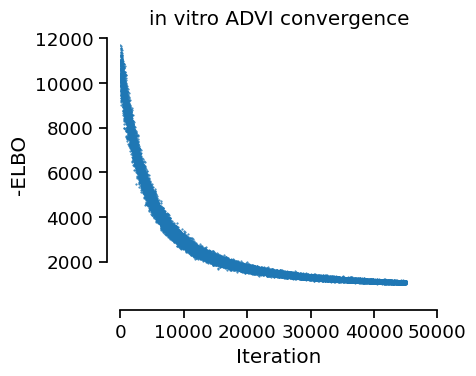

In [7]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, 50000])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)

trace_ADVI = run_ADVI(BIOMD64)

In [8]:
BMCA_obj = BIOMD64
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
    pm.Deterministic('en', e_obs)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
    pm.Deterministic('chin', chi_obs)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
    pm.Deterministic('yn', y_obs)
    likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    pm.Deterministic('v_hat', v_hat_obs)

    trace = pm.sample(1000, random_seed=1, cores=4)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: Ru

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3556 seconds.


In [ ]:
Ex = (trace['posterior']['Ex']).to_numpy()
Ey = (trace['posterior']['Ey']).to_numpy()
Ex_advi = (trace_ADVI['posterior']['Ex']).to_numpy().squeeze()
Ey_advi = (trace_ADVI['posterior']['Ey']).to_numpy().squeeze()

In [11]:
def reshape_elasticity(E):
    tmp = []
    for i in E: 
        tmp.append(i)
    return np.concatenate(tmp)

Ex = reshape_elasticity(Ex)
Ey = reshape_elasticity(Ey)

C:\Users\user\AppData\Local\Temp\ipykernel_12968\327435068.py:20: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



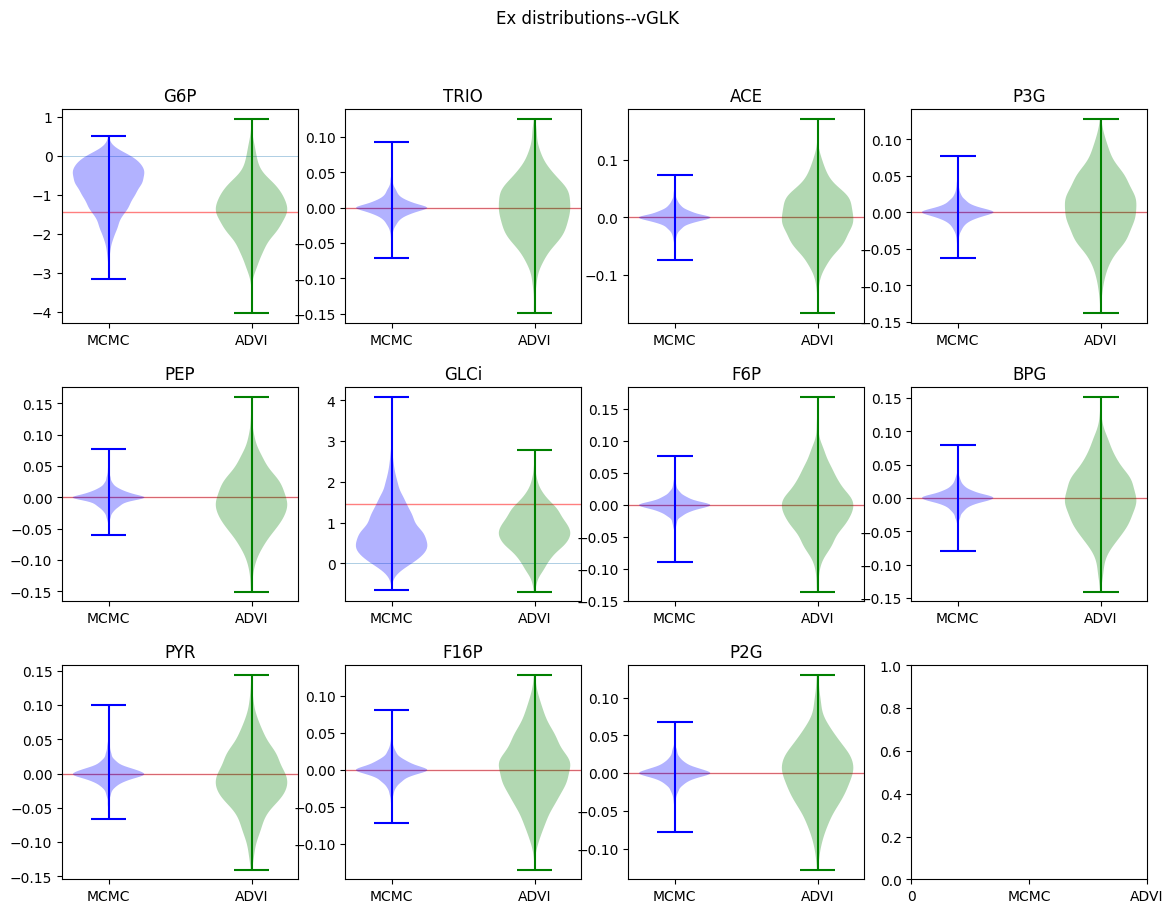

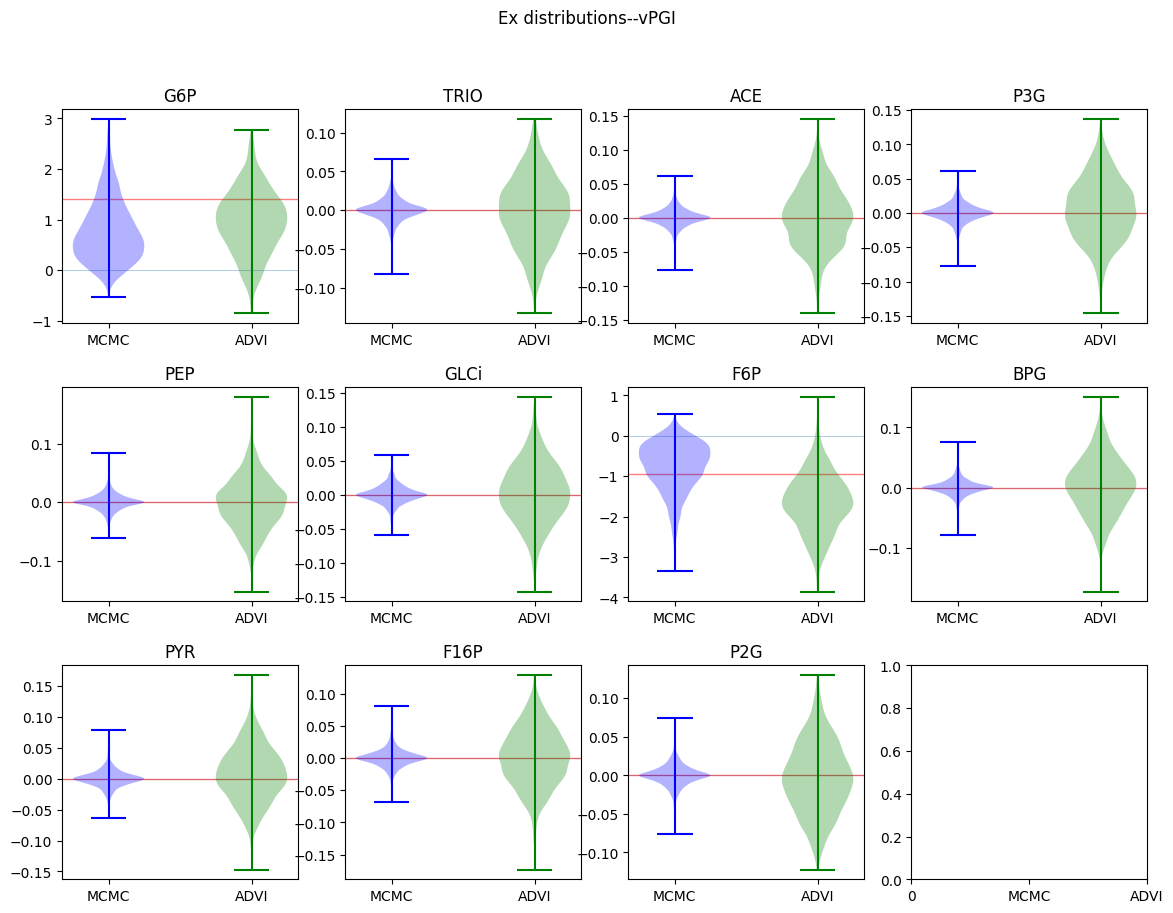

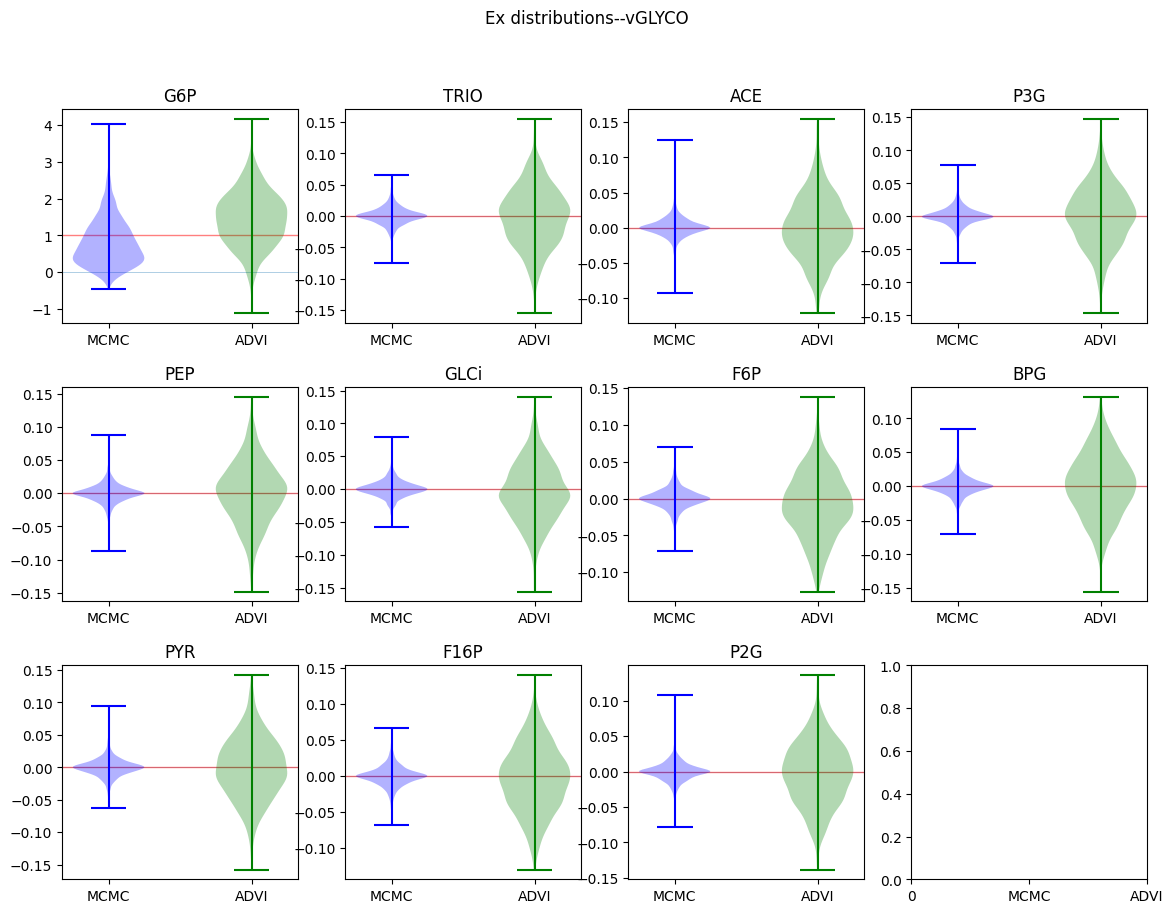

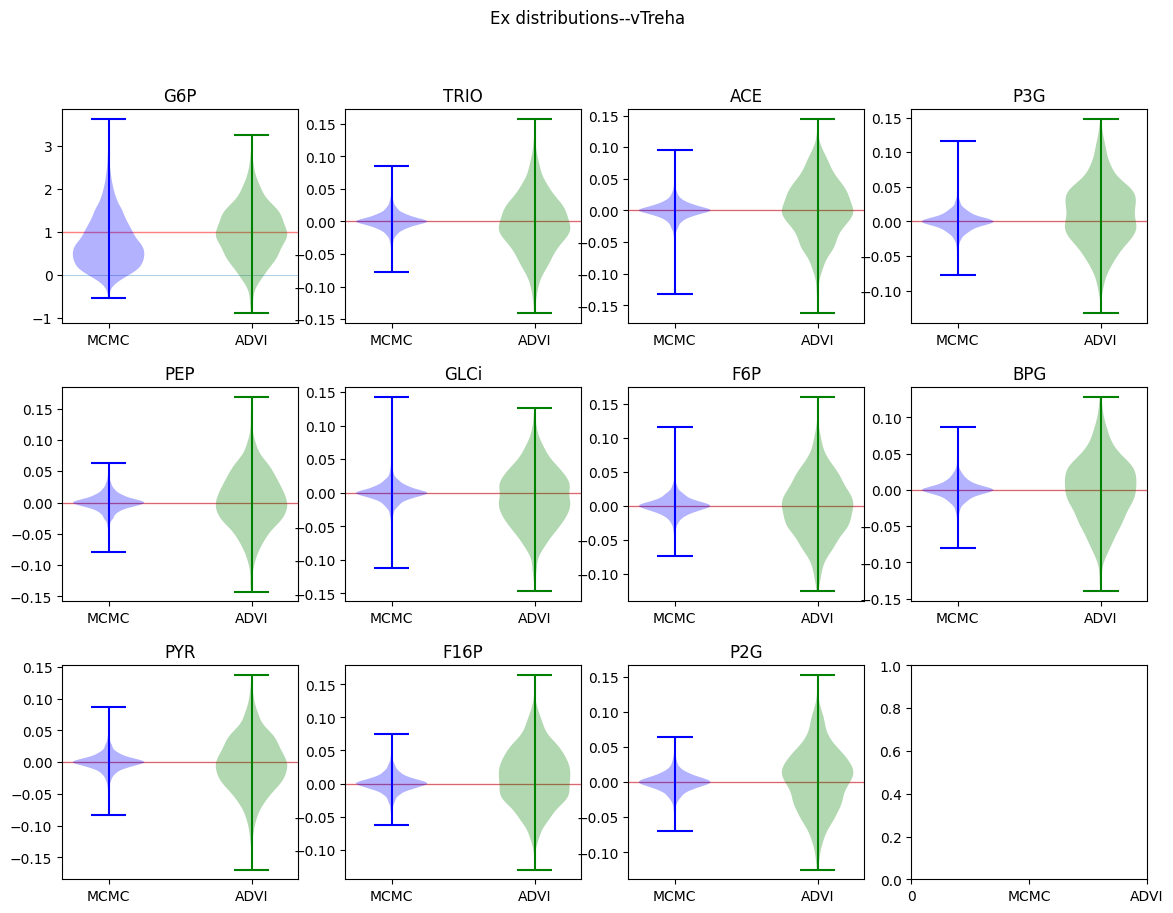

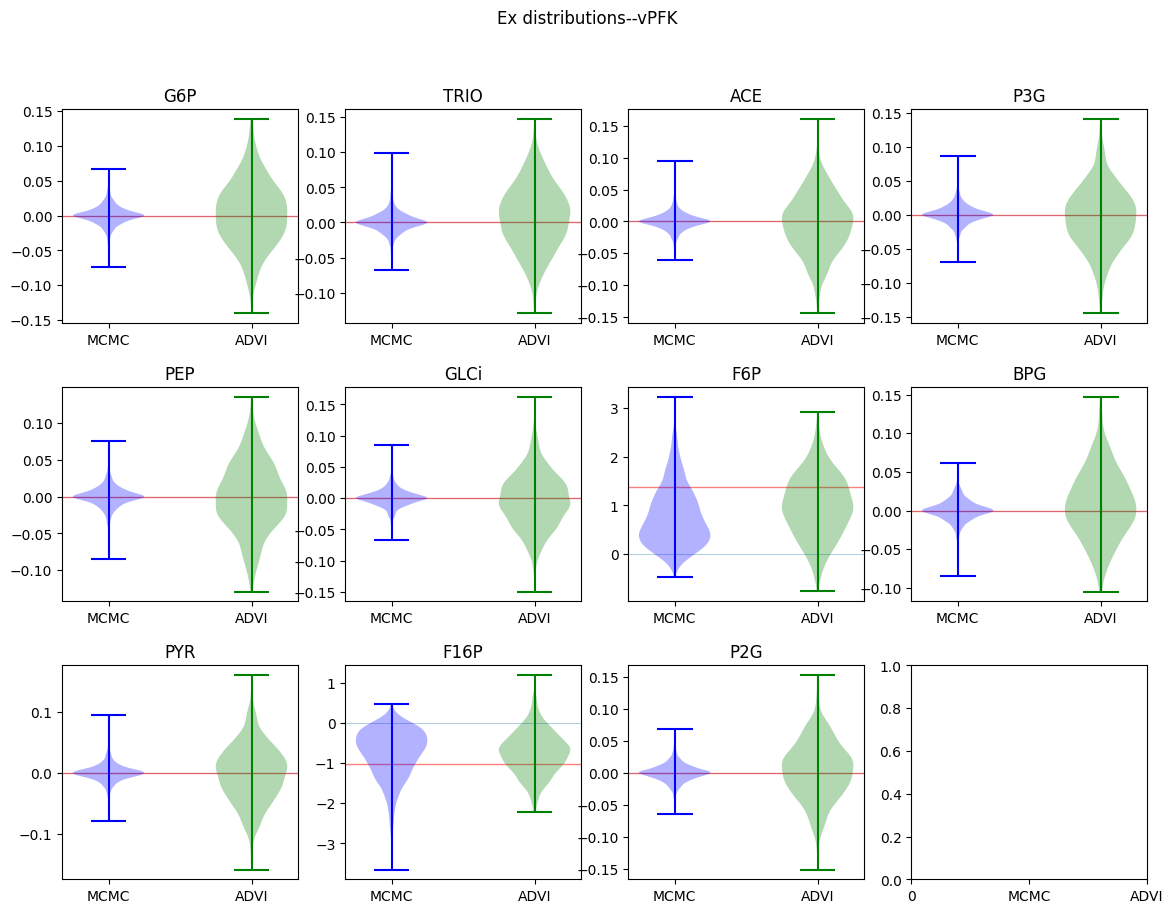

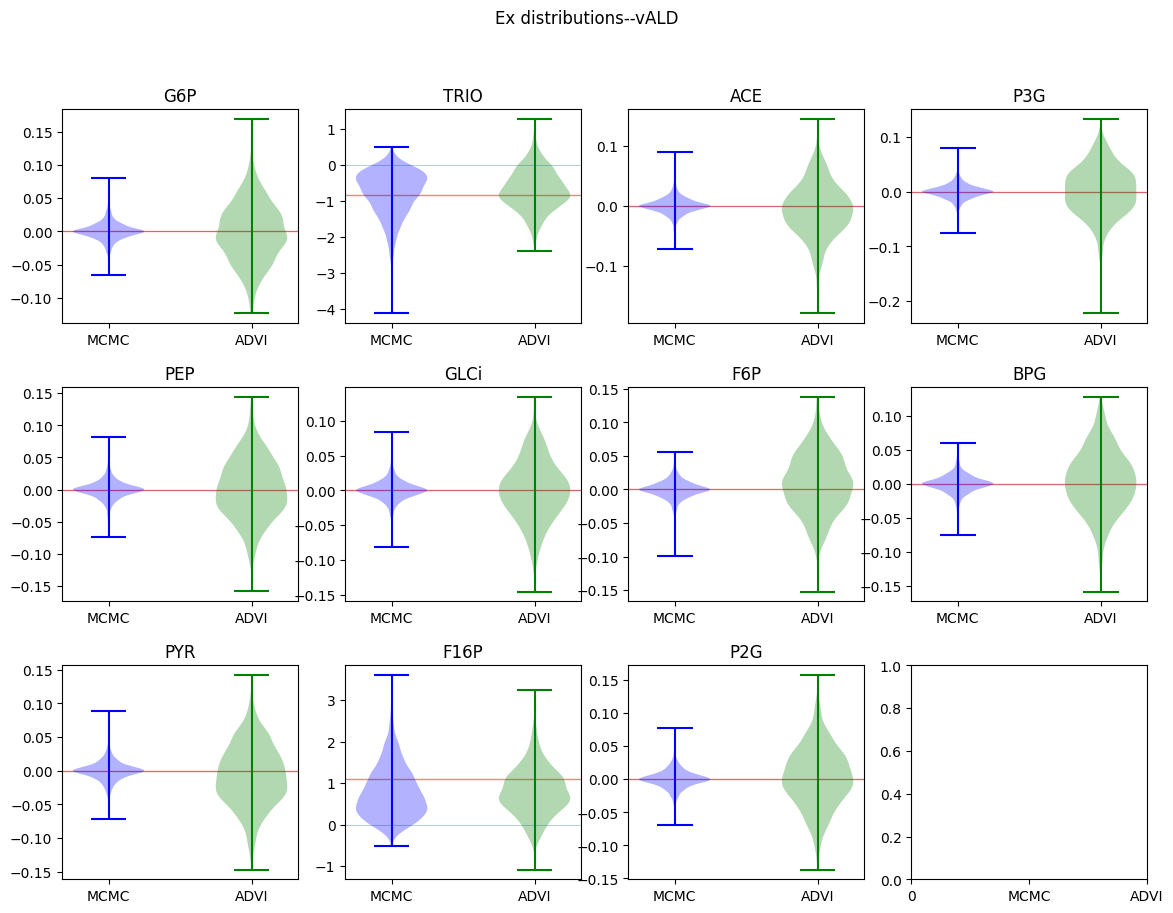

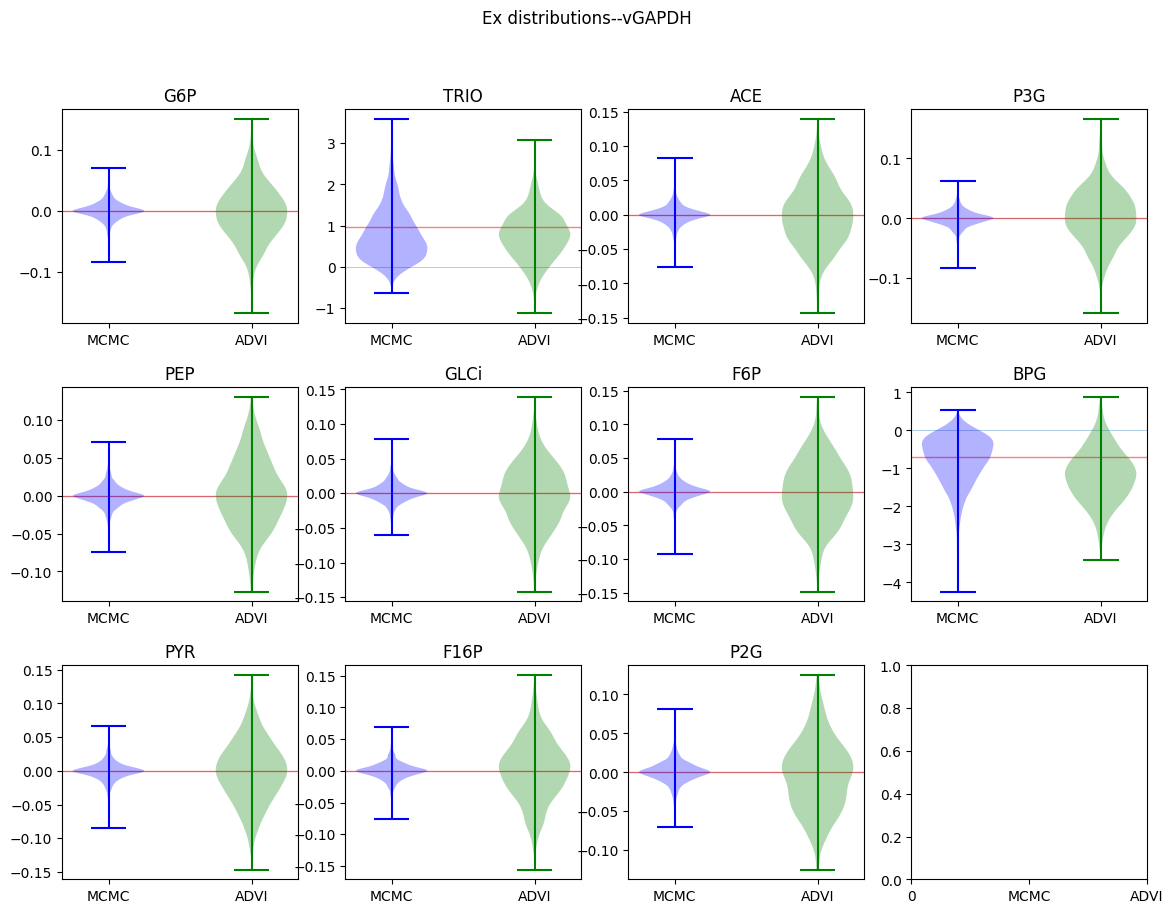

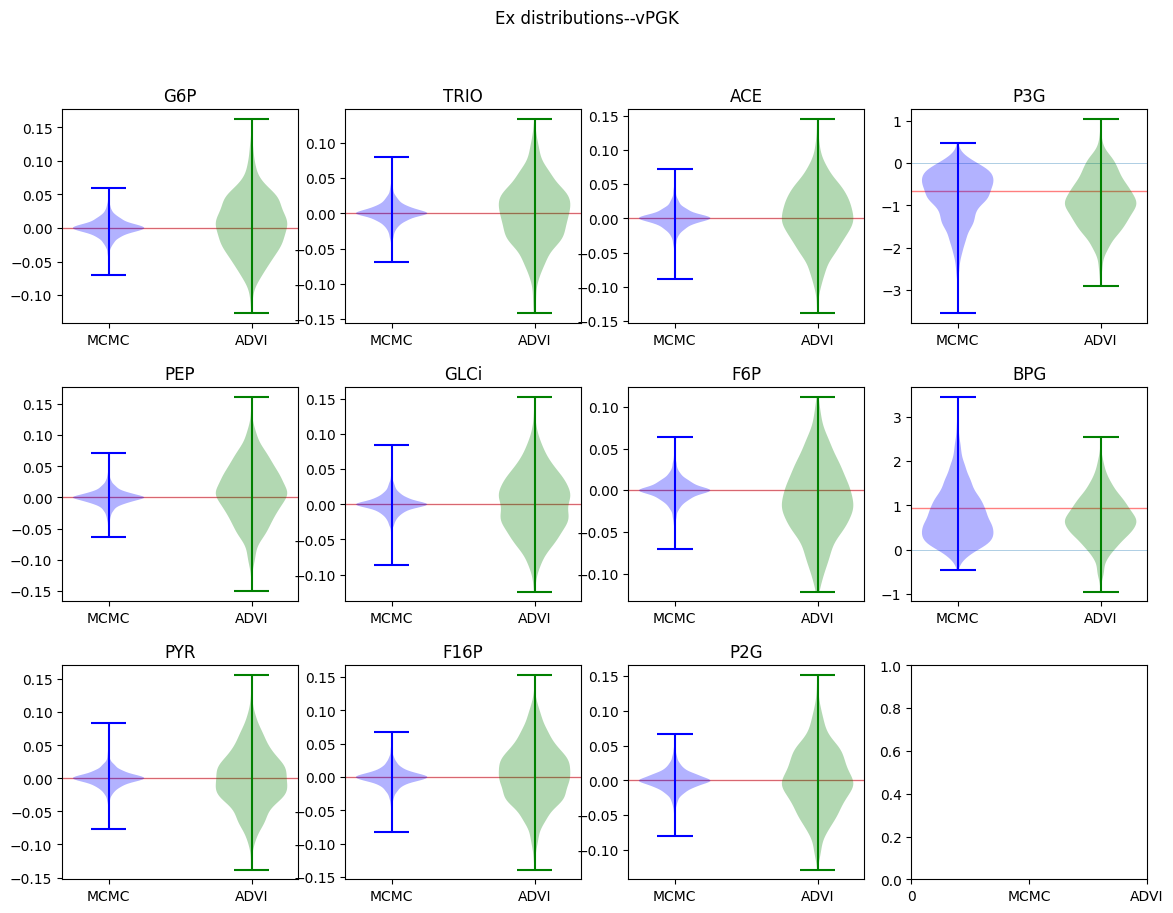

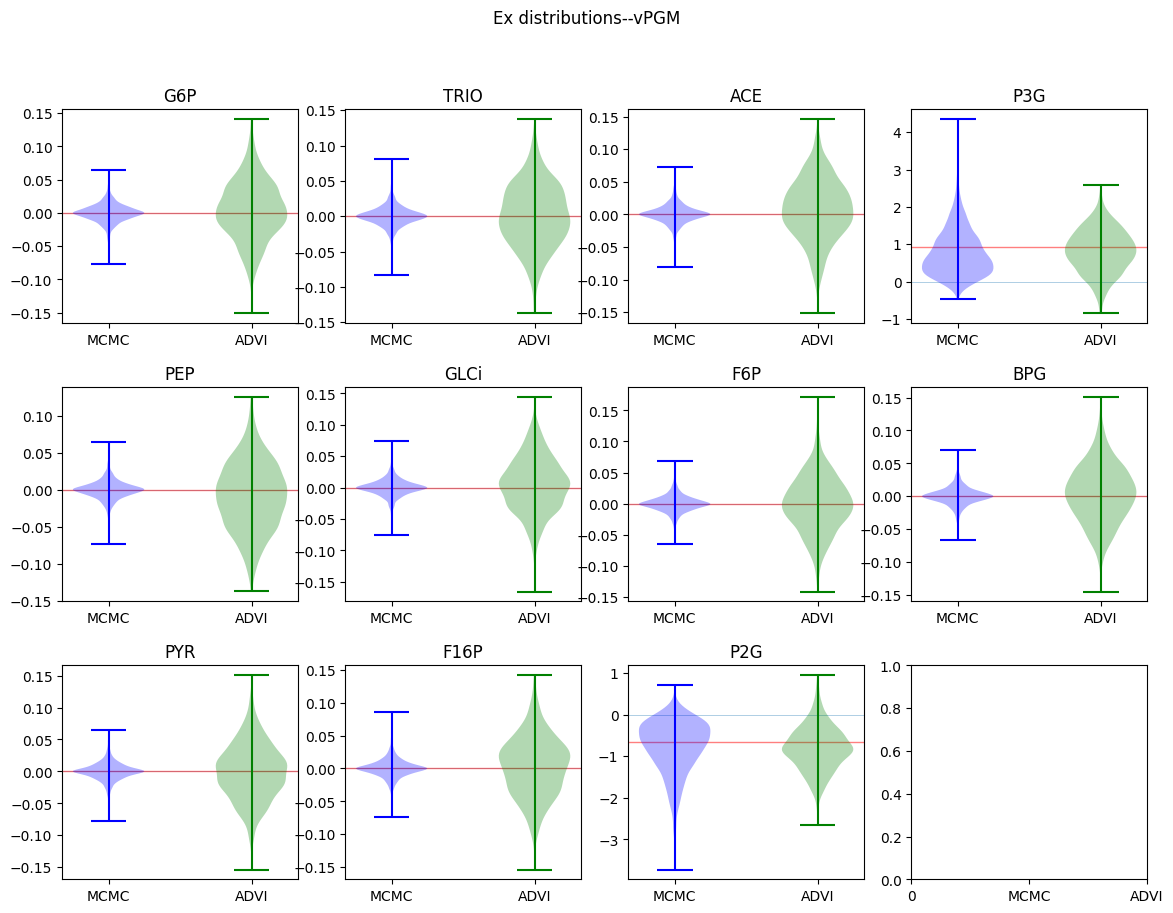

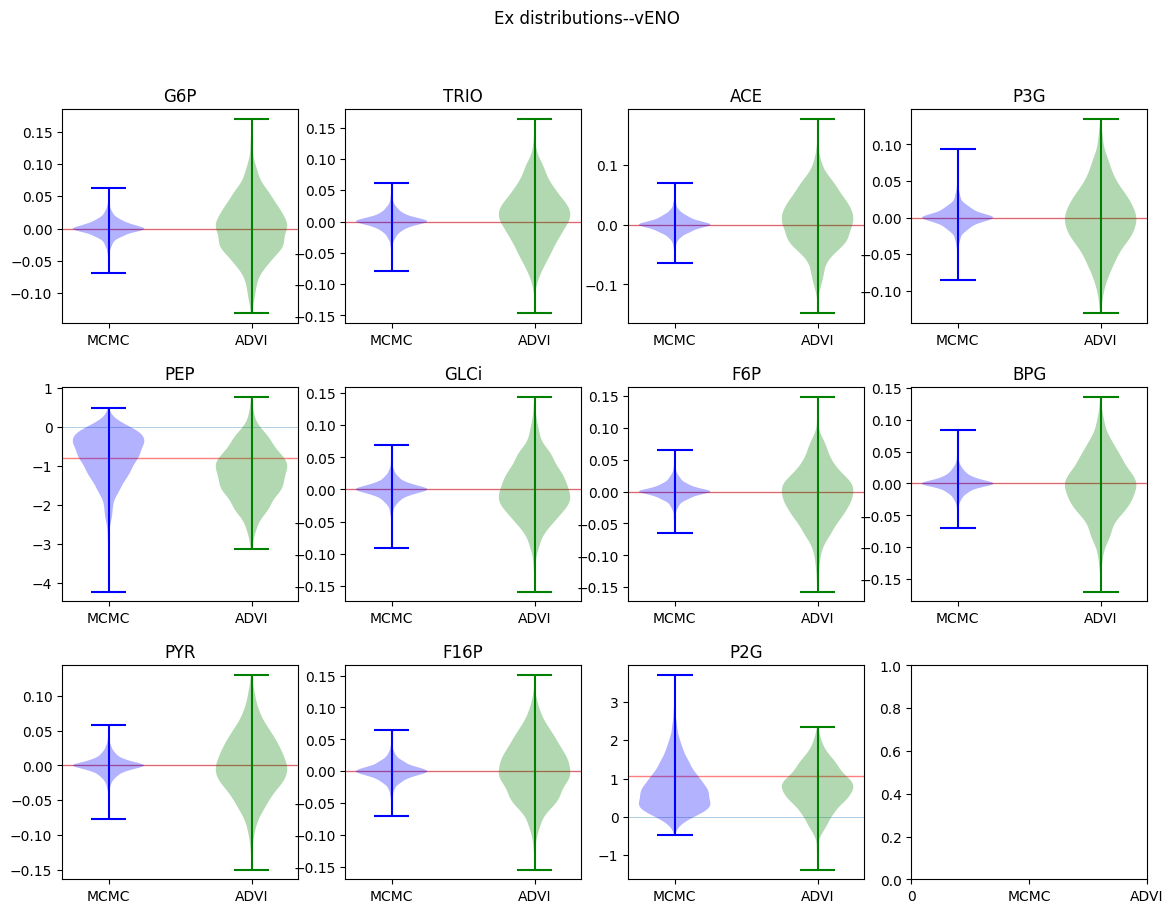

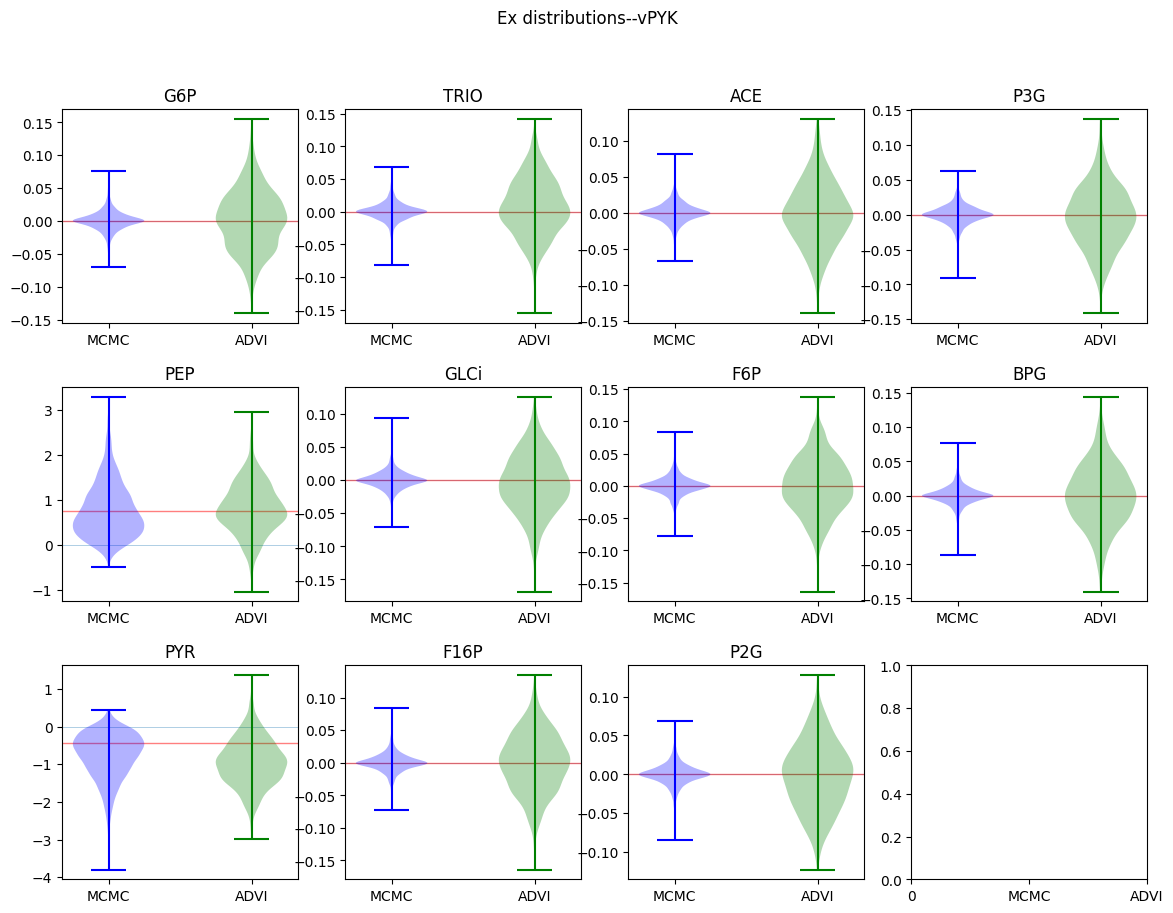

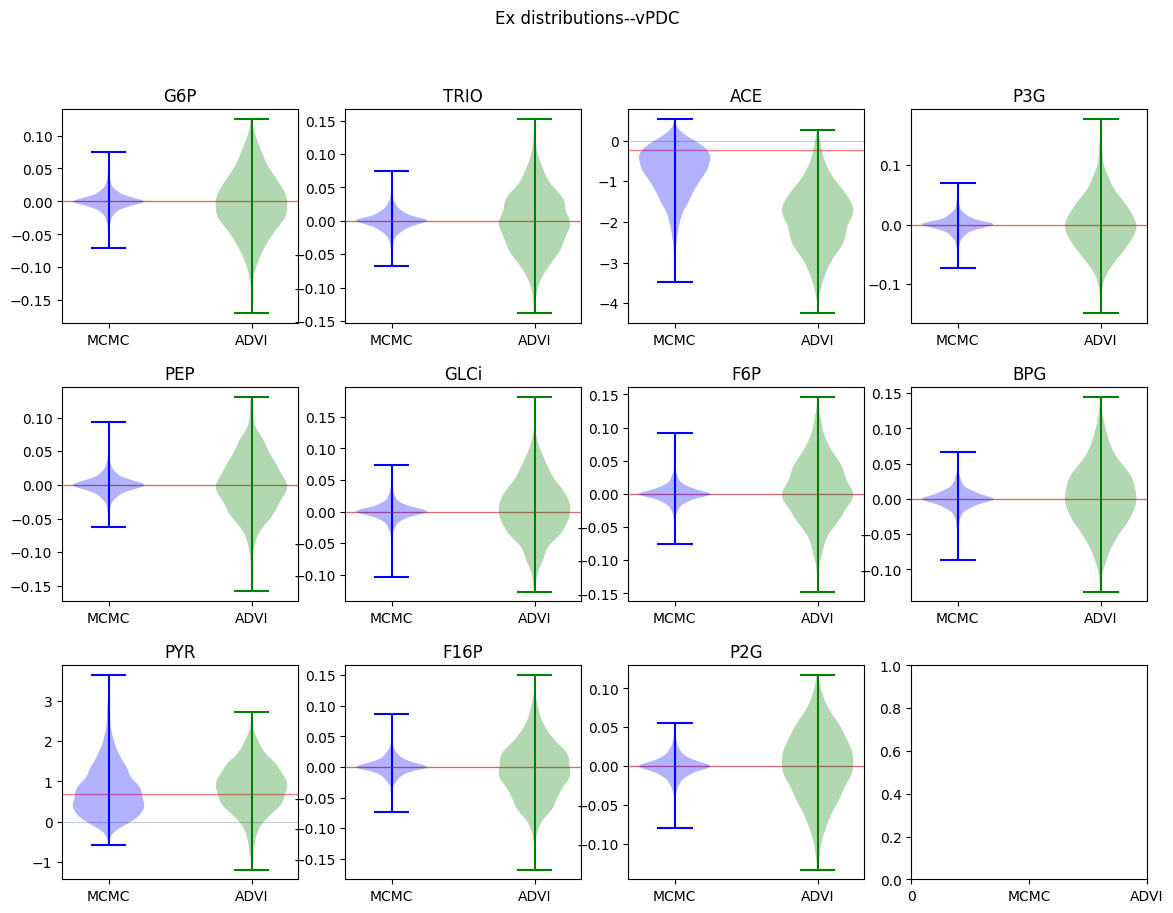

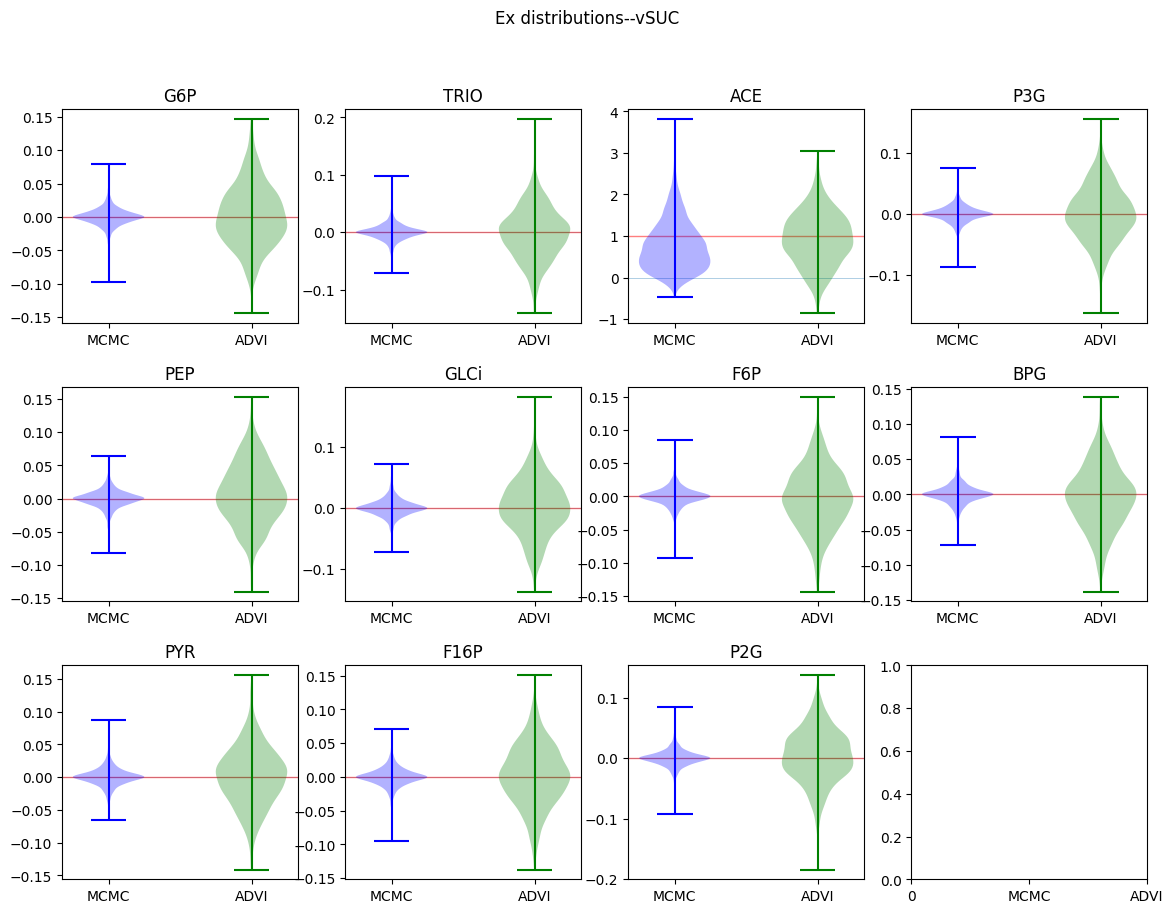

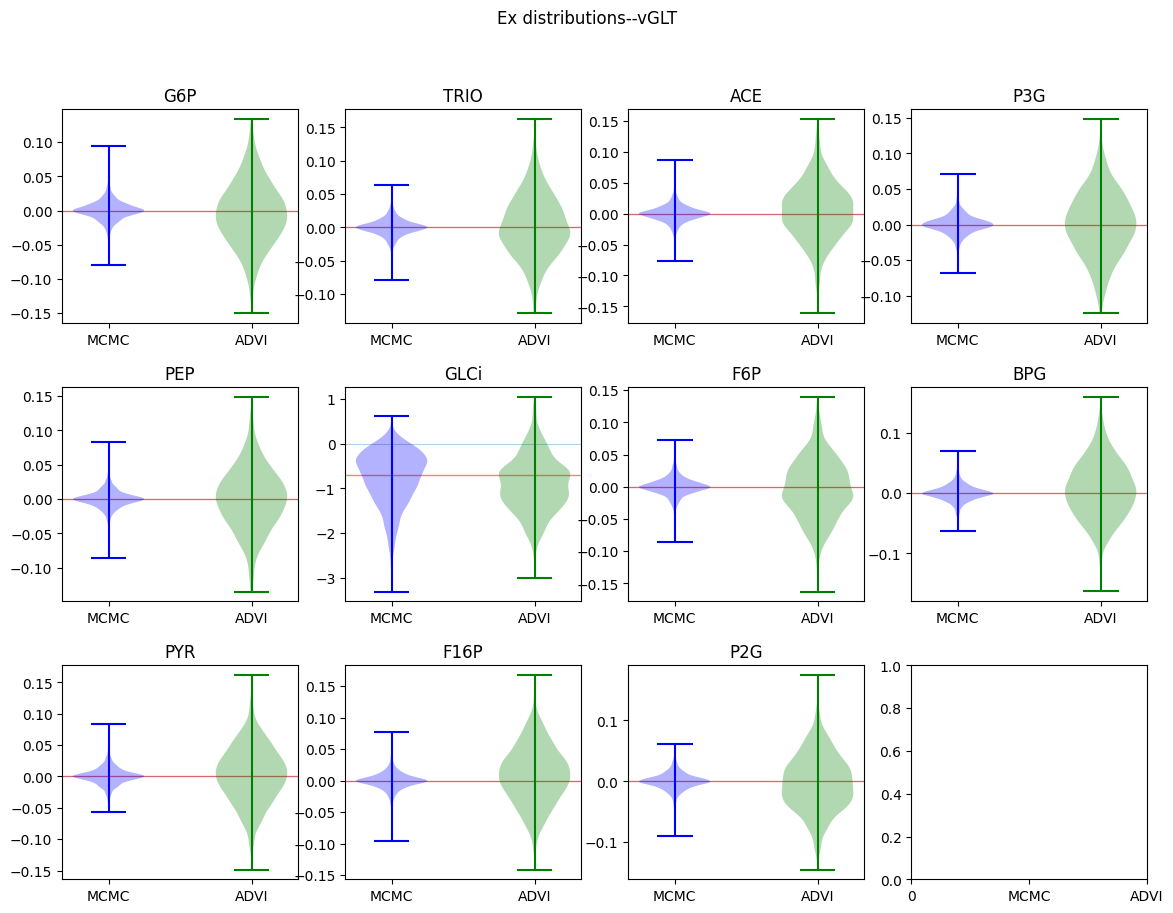

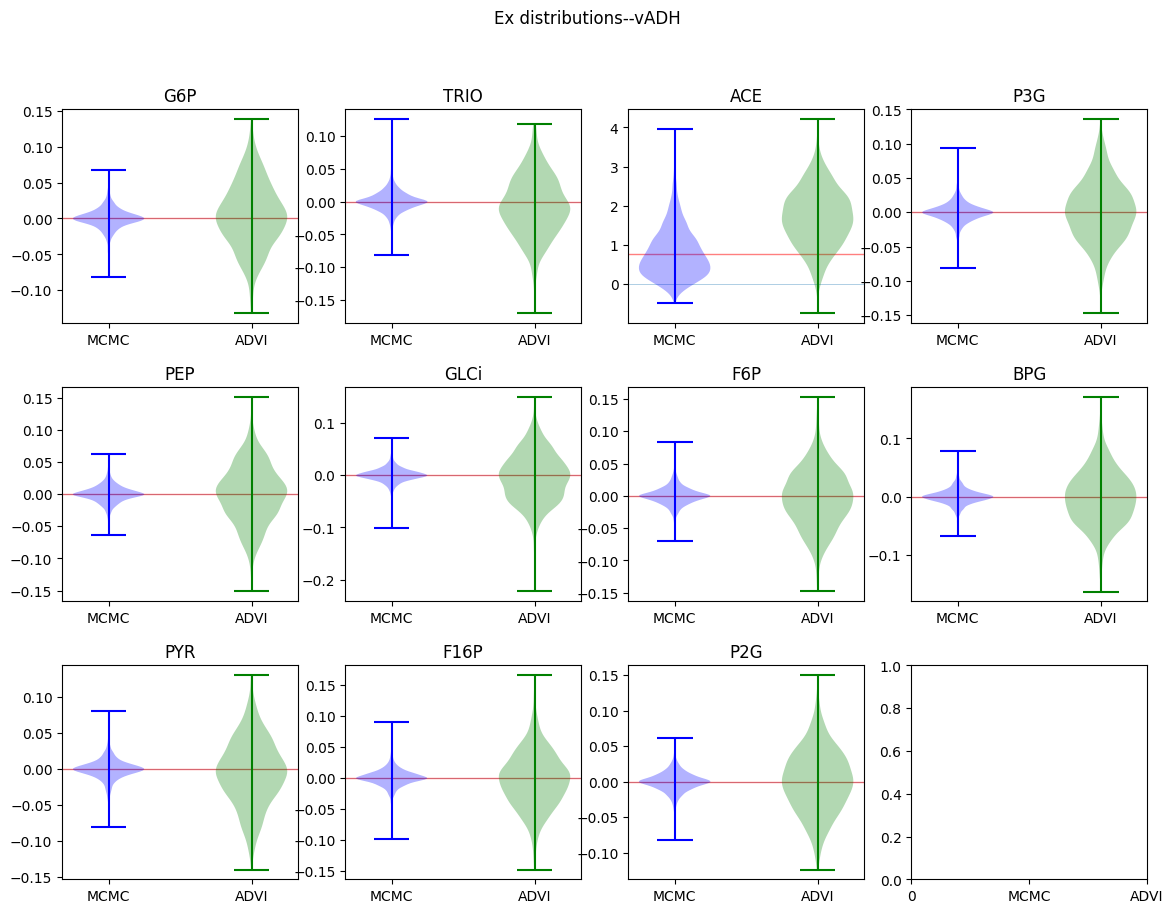

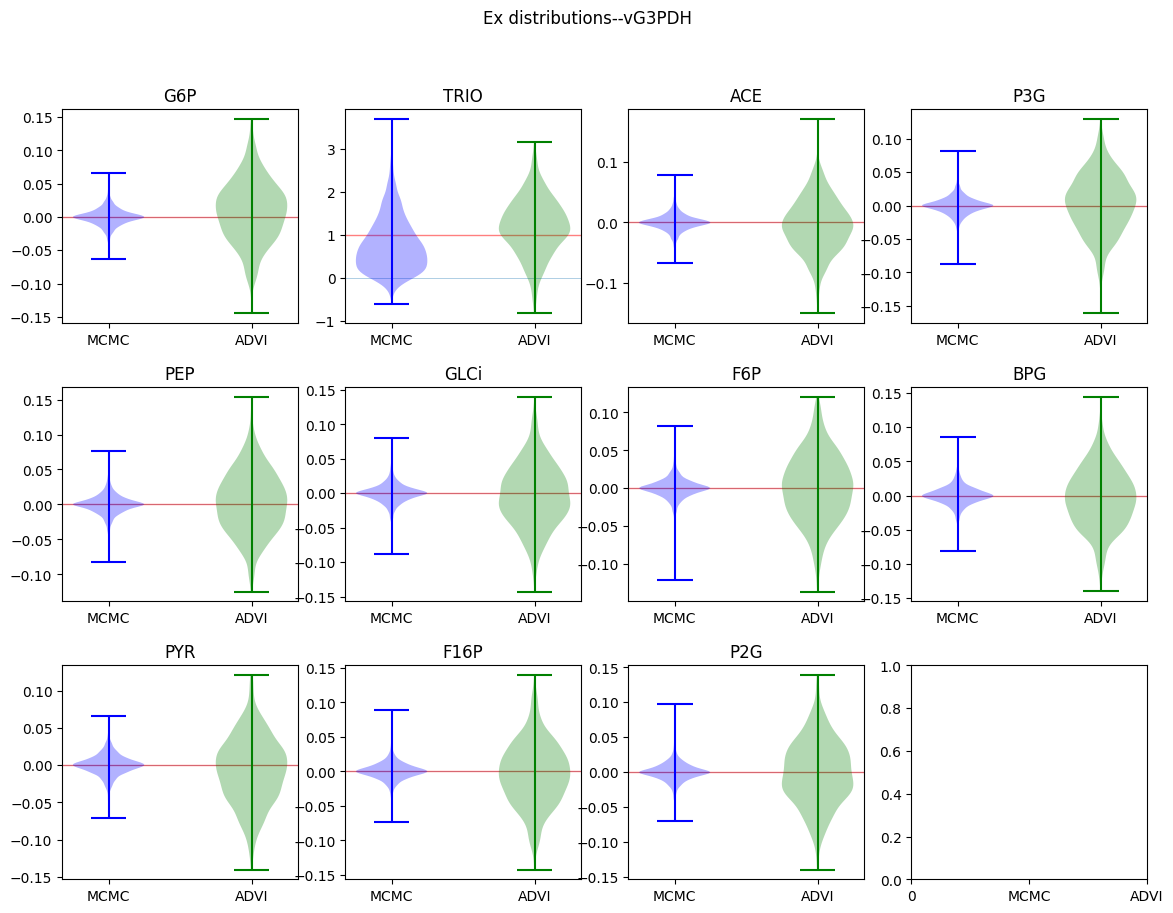

In [17]:
colors = ['blue', 'green', '#fa8602', 'magenta', '#07f53b', '#2312b8']

for i,rxn in enumerate(r.getReactionIds()): #['vADH']
    
    fig, ax = plt.subplots(3,4, figsize = (14,10))
    ii=-1
    
    fig.suptitle(f'Ex distributions--{rxn}\n')
    plt.setp(ax, xticks=range(3), xticklabels=[0,'MCMC', 'ADVI'])
    plt.subplots_adjust(hspace=0.3)
    
    for j,met in enumerate(r.getFloatingSpeciesIds()): # ['TRIO'])
        if j%4==0:
            ii += 1

        met_traces=[]
        for trace in [Ex.transpose(1, 2, 0), Ex_advi.transpose(1,2,0)]: 
            met_traces.append(trace[i,j,:]) 
            
        met_traces = np.array(met_traces).T

        plots = ax[ii, j%4].violinplot(met_traces)

        # Set the color of the violin patches
        for pc, color in zip(plots['bodies'], colors):
            pc.set_facecolor(color)
        plots['cbars'].set_colors(colors)
        plots['cmaxes'].set_colors(colors)
        plots['cmins'].set_colors(colors)
        
        ax[ii, j%4].axhline(0, linewidth=0.5, zorder=0, alpha=0.5)
        ax[ii, j%4].axhline(r.getScaledElasticityMatrix()[i,j], linewidth=1, zorder=0, alpha=0.5,color='red')
        ax[ii, j%4].set_title(met)
    
    # fig.delaxes(ax[3,2]) 
    # fig.delaxes(ax[3,3]) 

## Backcalculating to check if there are multiple elasticity solutions

In [18]:
med_Ex = np.median(Ex, axis=0)
med_Ey = np.median(Ey, axis=0)
med_Ex_advi = np.median(Ex_advi, axis=0)
med_Ey_advi = np.median(Ey_advi, axis=0)

In [19]:
BMCA_obj.vn
# d_df is the flux calculated using the Bayesian inference MCMC POSTERIORS for elasticity
MCMC_vn = BMCA_obj.en.values * (np.ones(BMCA_obj.en.T.shape) + med_Ex@(BMCA_obj.xn.T) + med_Ey@(BMCA_obj.yn.T)).T
MCMC_vn_df = pd.DataFrame(MCMC_vn)
MCMC_vn_df.columns = BMCA_obj.vn.columns #r.getReactionIds()
# MCMC_vn_df

In [20]:
BMCA_obj.vn
# d_df is the flux calculated using the Bayesian inference ADVI POSTERIORS for elasticity
advi_vn = BMCA_obj.en.values * (np.ones(BMCA_obj.en.T.shape) + med_Ex_advi@(BMCA_obj.xn.T) + med_Ey_advi@(BMCA_obj.yn.T)).T
advi_vn_df = pd.DataFrame(advi_vn)
advi_vn_df.columns = BMCA_obj.vn.columns #r.getReactionIds()
# advi_vn_df

Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

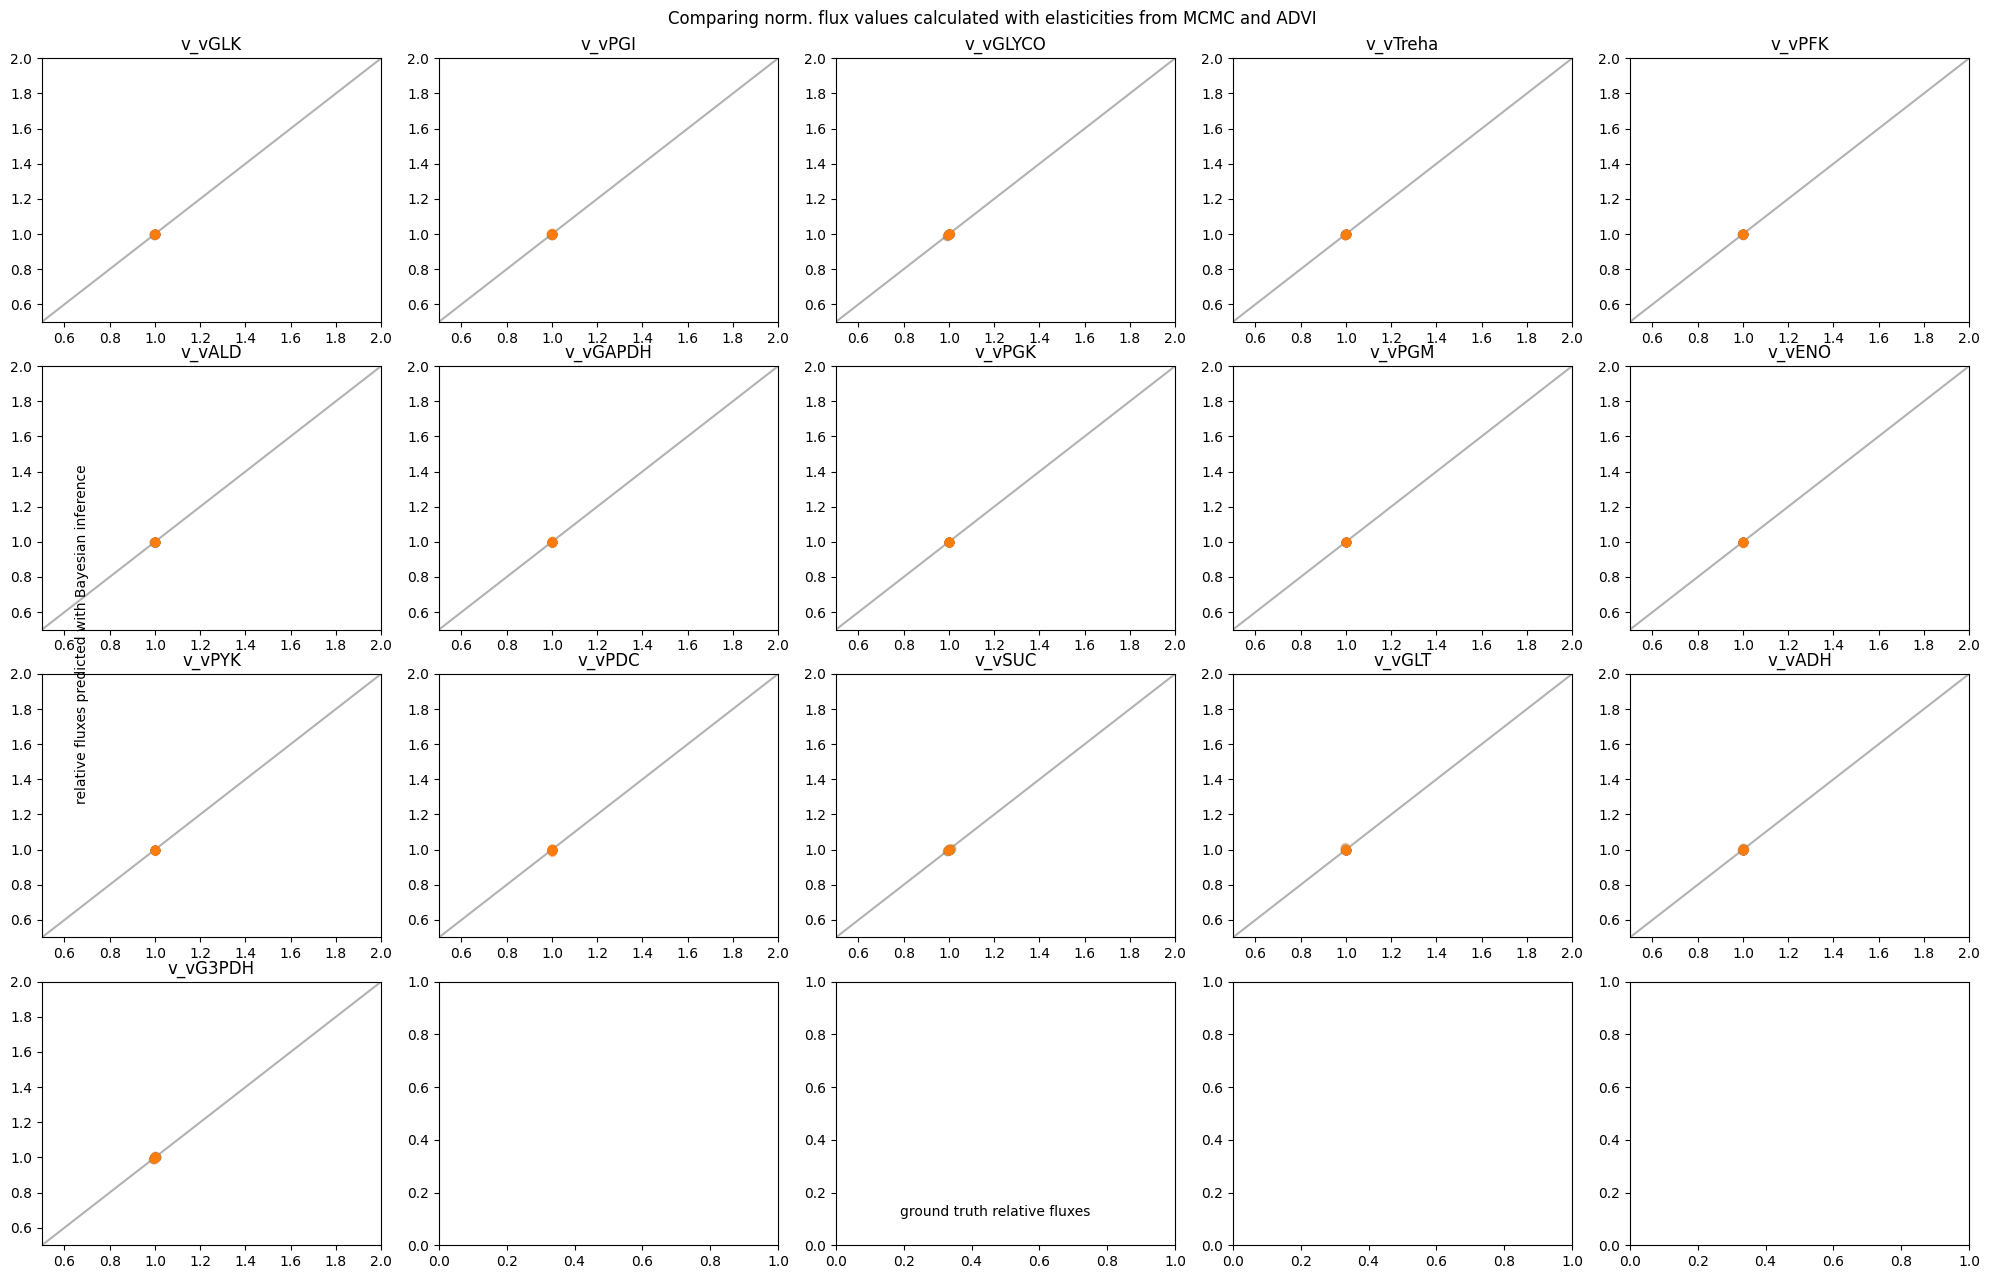

In [21]:
fig, axs = plt.subplots(4,5, figsize=(20, 13)) 
idx_starter = -1

fig.suptitle('Comparing norm. flux values calculated with elasticities from MCMC and ADVI \n')
fig.tight_layout()

lims = [0.5,2]

for i,col in enumerate(MCMC_vn_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(BMCA_obj.vn[col], MCMC_vn_df[col], alpha=0.3)
    axs[idx_starter, i%5].scatter(BMCA_obj.vn[col], advi_vn_df[col], alpha=0.3)
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

### Subtracting the vn values from fluxes calculated using elasticity posteriors

In [24]:
mcmc_dif = MCMC_vn_df-BMCA_obj.vn
# mcmc_dif[mcmc_dif < 1E-1] = 0 
mcmc_dif

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,-4.186937e-03,1.183197e-03,8.530145e-04,9.007028e-04,1.053016e-03,0.000837,7.302632e-04,6.240302e-04,6.720323e-04,5.935509e-04,4.911929e-04,0.000422,0.000285,1.080587e-04,9.194297e-05,8.432505e-04
2,2.518636e-04,-2.636705e-03,-3.385155e-04,-3.581630e-04,2.308044e-03,0.001833,1.601086e-03,1.368683e-03,1.474085e-03,1.300920e-03,1.079609e-03,0.000925,0.000624,3.057200e-05,2.012465e-04,1.837591e-03
3,9.273639e-05,-1.713438e-04,-1.230472e-04,-1.313899e-04,-1.526085e-04,-0.000121,-1.057634e-04,-9.038357e-05,-9.747232e-05,-8.595260e-05,-7.128920e-05,-0.000061,-0.000041,9.953162e-06,-1.329906e-05,-1.227662e-04
4,9.515572e-04,-1.755751e-03,-1.281802e-03,-1.341024e-03,-1.563622e-03,-0.001244,-1.082843e-03,-9.252862e-04,-9.979306e-04,-8.800351e-04,-7.298495e-04,-0.000626,-0.000425,1.022967e-04,-1.364692e-04,-1.264074e-03
5,1.725047e-04,2.683583e-04,-2.326853e-04,-2.452402e-04,-3.628730e-03,0.001263,1.104613e-03,9.421340e-04,1.013325e-03,8.970176e-04,7.443046e-04,0.000637,0.000432,2.037701e-05,1.376386e-04,1.270014e-03
6,1.620715e-04,2.519609e-04,-2.189122e-04,-2.288175e-04,-4.518367e-05,-0.002691,1.034128e-03,8.827108e-04,9.504850e-04,8.399960e-04,6.977486e-04,0.000600,0.000404,1.669547e-05,1.276207e-04,1.192187e-03
7,7.646620e-05,1.214036e-04,-1.045927e-04,-1.077644e-04,-2.356435e-05,-0.000389,-1.410373e-03,1.532666e-03,1.646993e-03,1.457830e-03,1.208123e-03,0.001038,0.000697,8.929799e-06,2.203250e-04,-1.387576e-03
8,5.857569e-05,9.272291e-05,-7.871465e-05,-8.272420e-05,-1.591649e-05,-0.000294,-8.217025e-04,-1.506558e-03,1.251612e-03,1.107606e-03,9.168574e-04,0.000788,0.000530,5.386527e-06,1.658111e-04,-1.053370e-03
9,4.253826e-05,6.632062e-05,-5.614493e-05,-6.156523e-05,-9.587784e-06,-0.000206,-5.808218e-04,-1.185886e-03,-2.191684e-03,7.799547e-04,6.472828e-04,0.000557,0.000374,4.426077e-06,1.148269e-04,-7.438474e-04


In [25]:
advi_dif = advi_vn_df-BMCA_obj.vn
# advi_dif[advi_dif < 1E-1] = 0 
advi_dif

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.001992,0.003189,-0.001229,-0.000006,0.000233,0.000778,0.001664,0.001215,0.000577,0.001291,0.000677,0.001244,0.000063,-0.000617,-0.000813,-0.000519
2,-0.000379,0.003919,0.000535,-0.000132,0.000548,0.001684,0.003639,0.002679,0.001265,0.002859,0.001523,0.002681,0.000119,-0.000212,-0.001736,-0.001054
3,-0.000160,-0.000460,0.000171,-0.000005,-0.000037,-0.000113,-0.000243,-0.000175,-0.000080,-0.000189,-0.000101,-0.000177,-0.000008,-0.000057,0.000115,0.000072
4,-0.001638,-0.004719,0.001762,-0.000060,-0.000376,-0.001159,-0.002485,-0.001790,-0.000823,-0.001938,-0.001037,-0.001811,-0.000084,-0.000585,0.001177,0.000728
5,-0.000277,-0.002295,0.000306,-0.000101,-0.002452,0.001225,0.002494,0.001752,0.000868,0.001930,0.001044,0.001870,0.000059,-0.000184,-0.001224,-0.000715
6,-0.000238,-0.002135,0.000258,-0.000003,0.000430,-0.002077,0.002365,0.001677,0.000864,0.001833,0.000993,0.001704,0.000075,-0.000094,-0.001175,-0.000703
7,-0.000097,-0.001065,0.000117,-0.000094,0.000240,-0.000472,0.001926,0.002934,0.001455,0.003259,0.001769,0.002952,0.000119,-0.000079,-0.002086,0.000812
8,-0.000099,-0.000770,0.000112,-0.000058,0.000244,-0.000327,-0.003640,-0.000463,0.001151,0.002429,0.001337,0.002271,0.000058,-0.000009,-0.001603,0.000580
9,-0.000009,-0.000510,0.000101,0.000062,0.000135,-0.000202,-0.002531,-0.003216,-0.000398,0.001690,0.000914,0.001588,0.000033,0.000005,-0.001123,0.000458


## Calculating FCCs

In [26]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [27]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return CCC.eval(), FCC


In [32]:
med_Ex.shape

(16, 11)

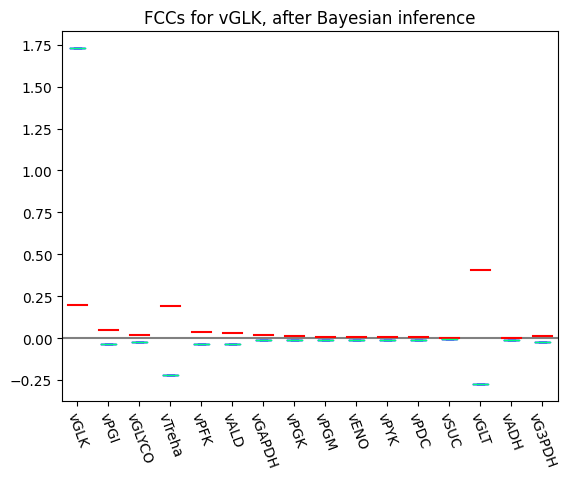

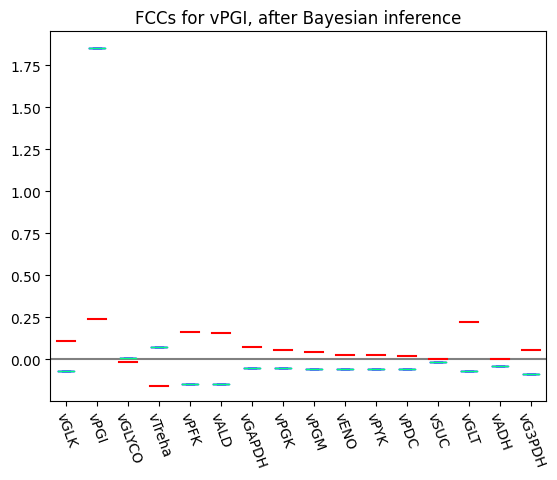

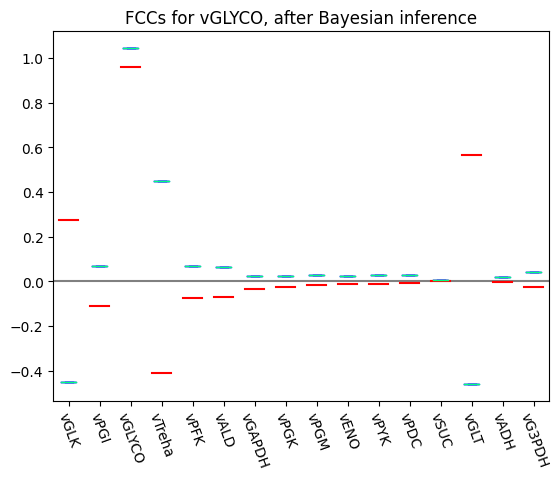

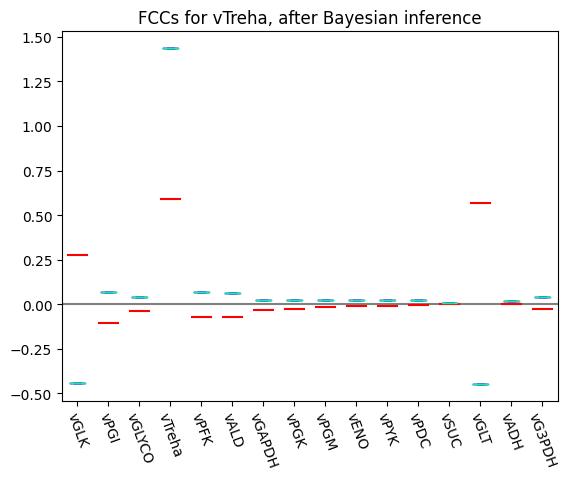

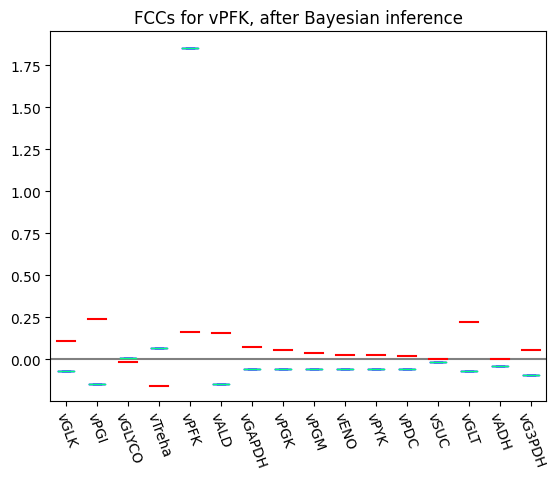

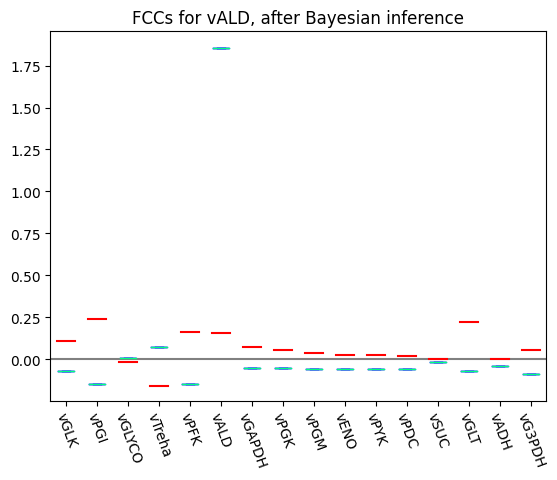

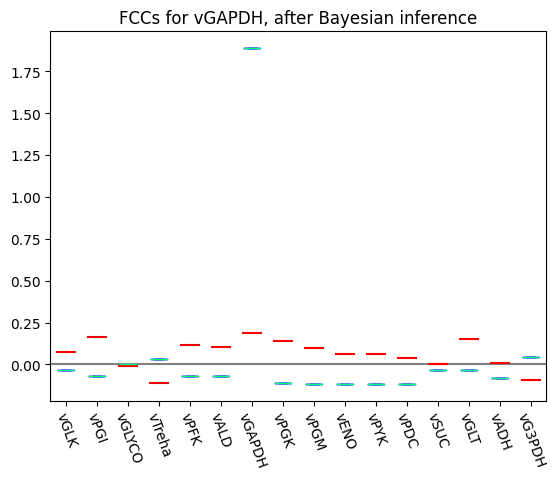

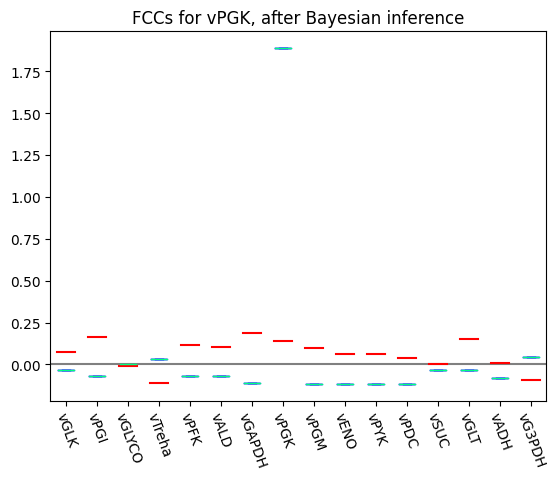

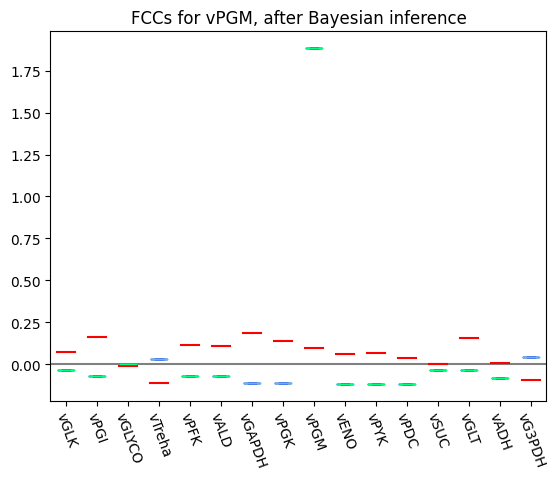

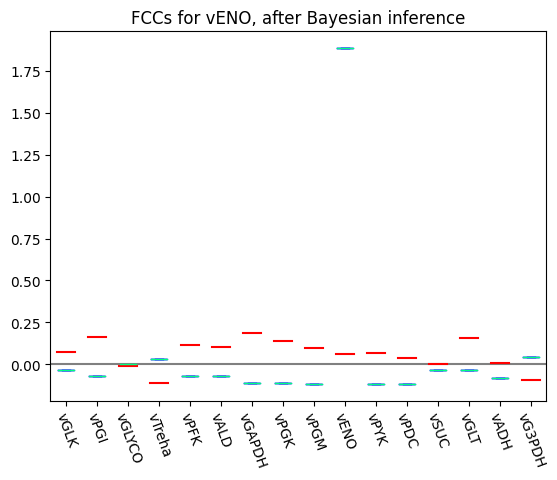

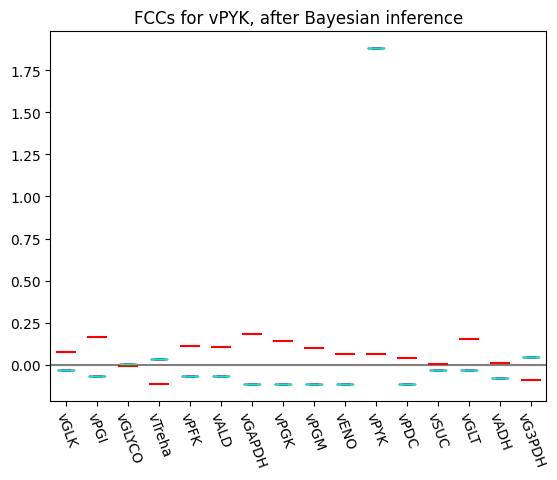

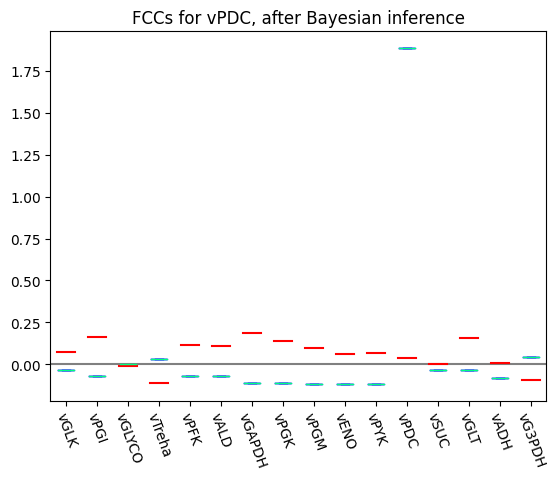

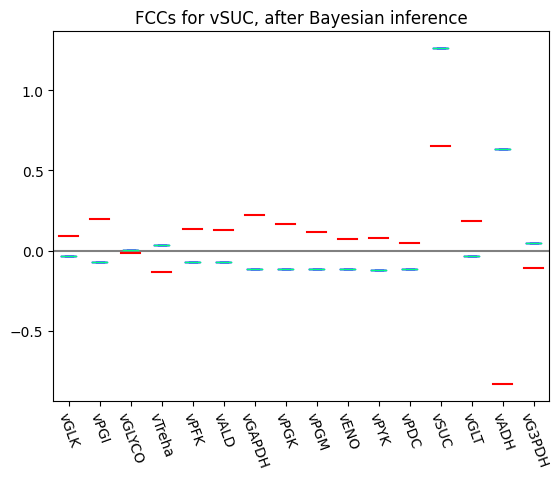

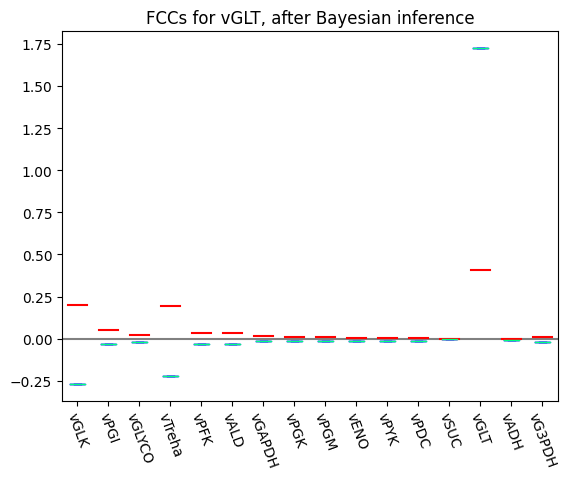

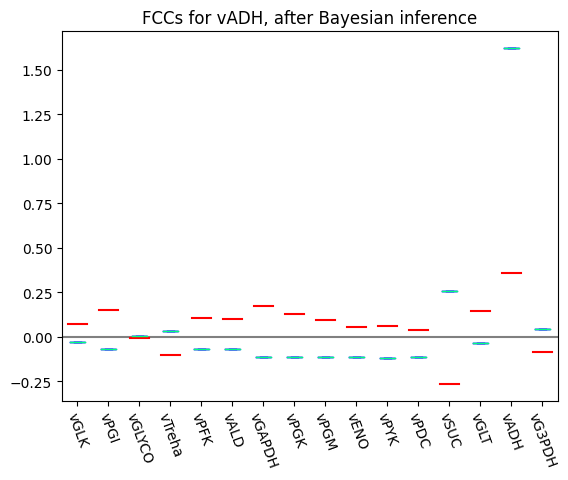

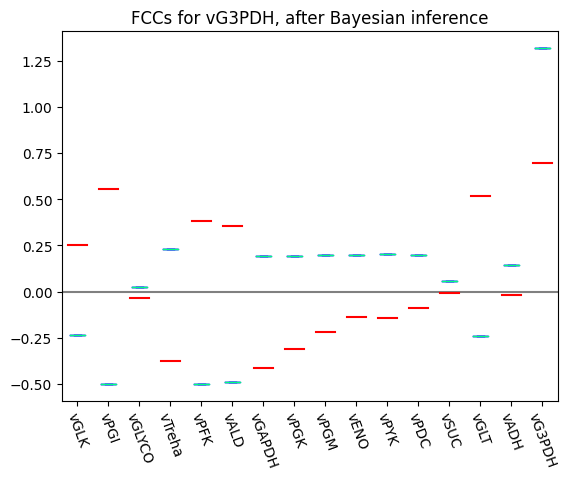

In [36]:
postCCC, postFCC = estimate_CCs(BIOMD64, med_Ex)
for i,rxnID in enumerate(r.getReactionIds()):
    # FCCs = -pd.DataFrame(postFCC[:,i,:], columns=r.getReactionIds())
    FCCs = pd.DataFrame(postFCC[:,i,:], columns=r.getReactionIds())

    FCCs.plot(kind='box', colormap='winter')
    plt.title(f'FCCs for {rxnID}, after Bayesian inference')
    plt.axhline(0, c='gray')

    for i,val in enumerate(gtFCC.loc[rxnID]): # .sort_index()
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[rxnID]), # From the left
                xmax = (i+0.8)/len(gtFCC[rxnID]), 
                c='red') # To the right
    plt.xticks(rotation=-70)
# plt.ylim((-1,3))

### Negative predictions

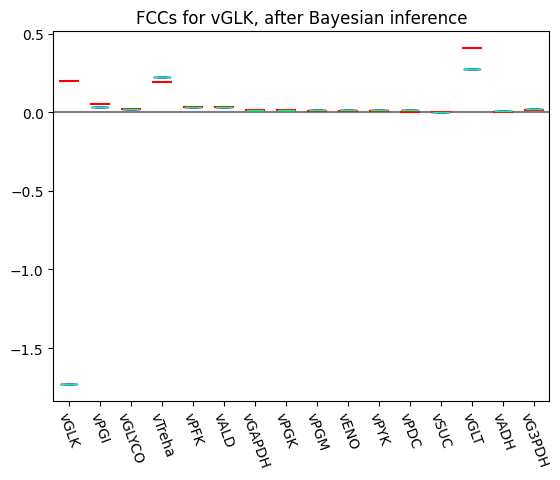

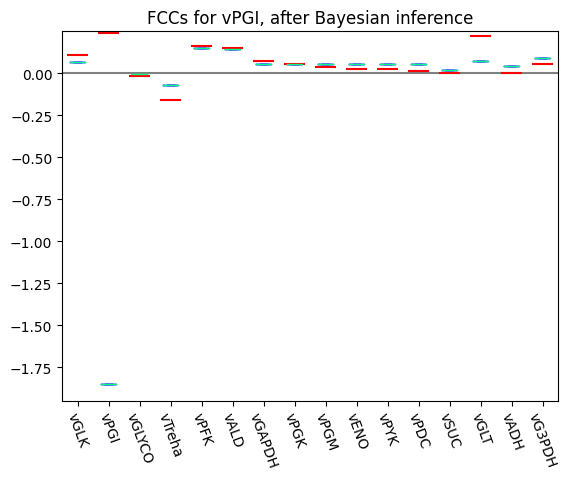

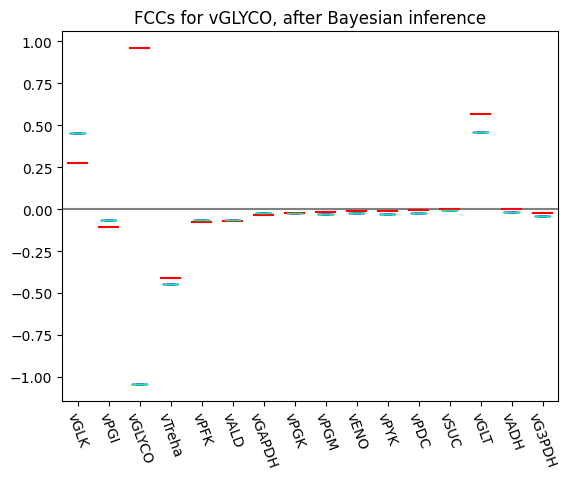

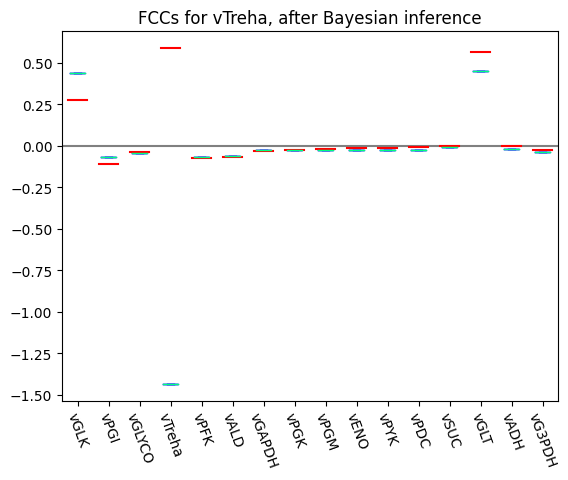

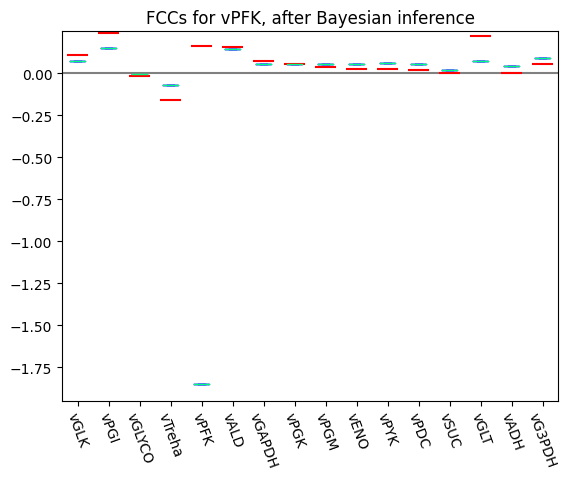

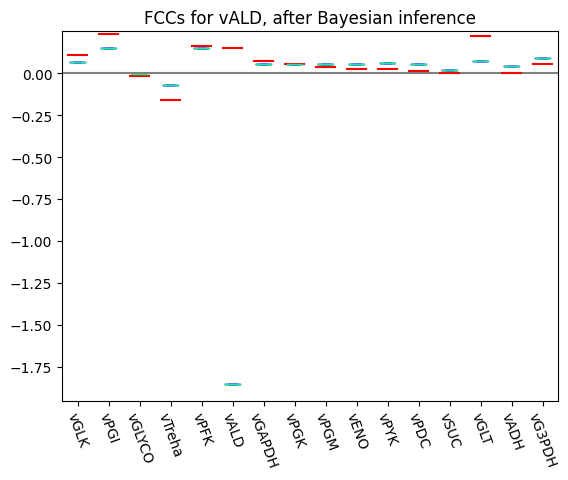

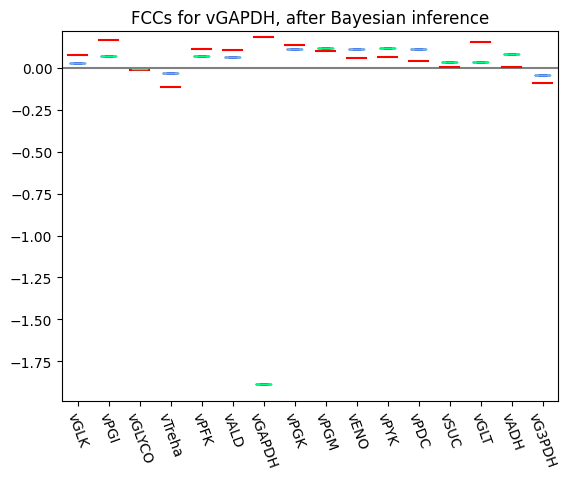

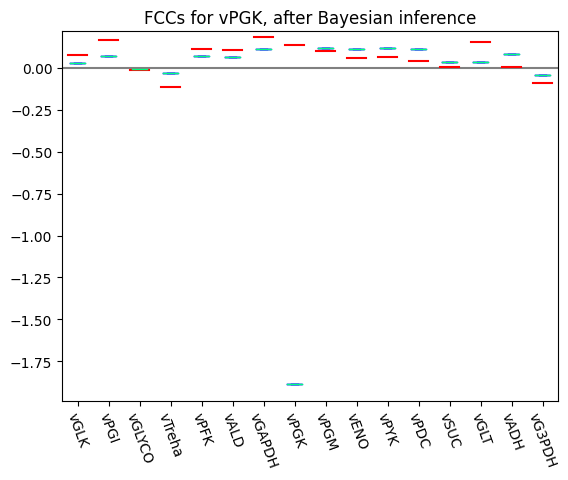

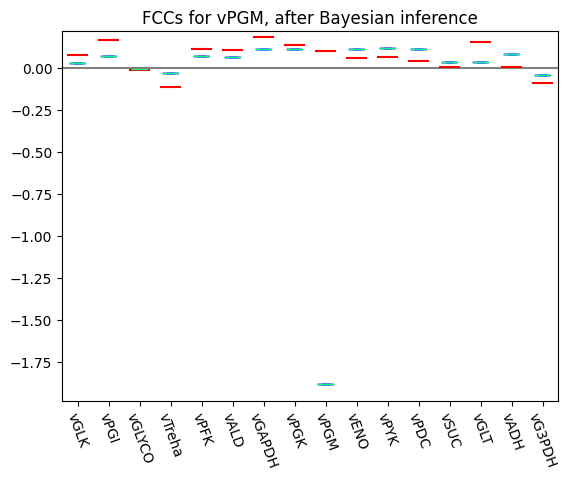

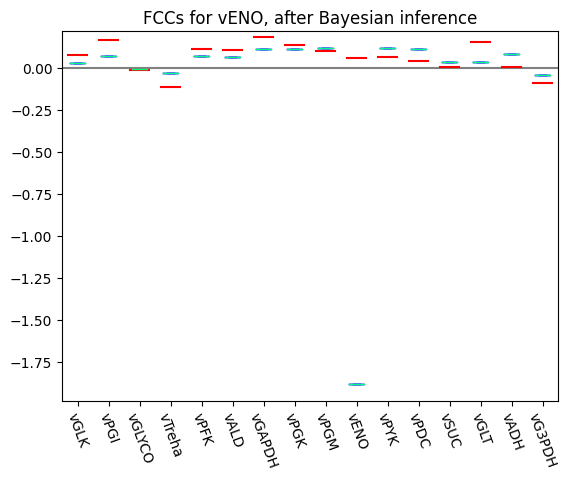

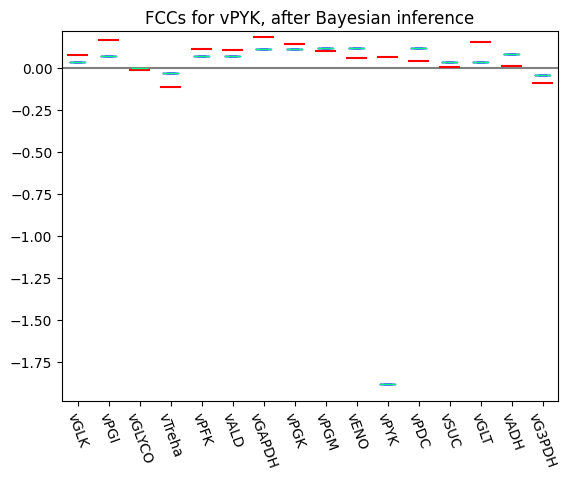

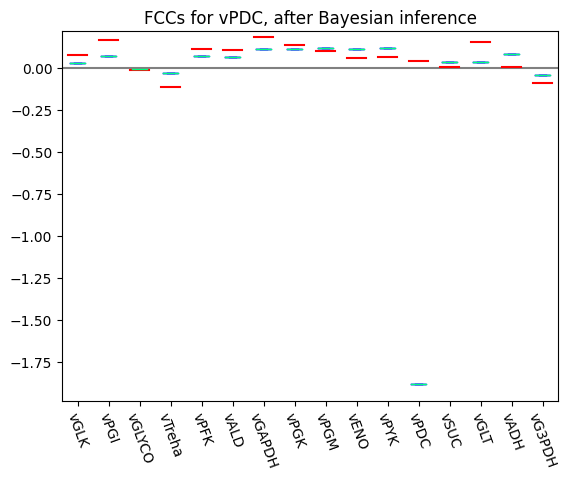

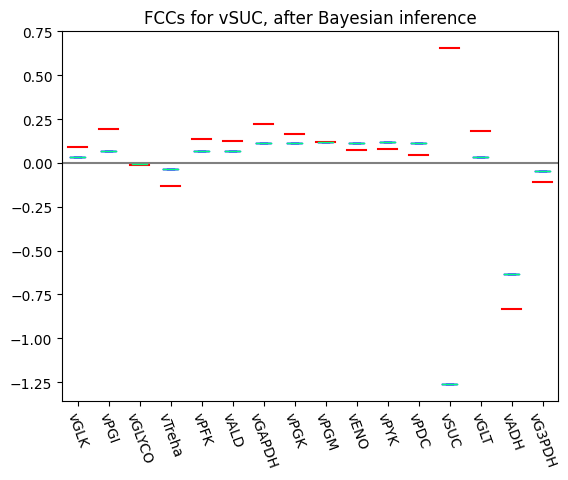

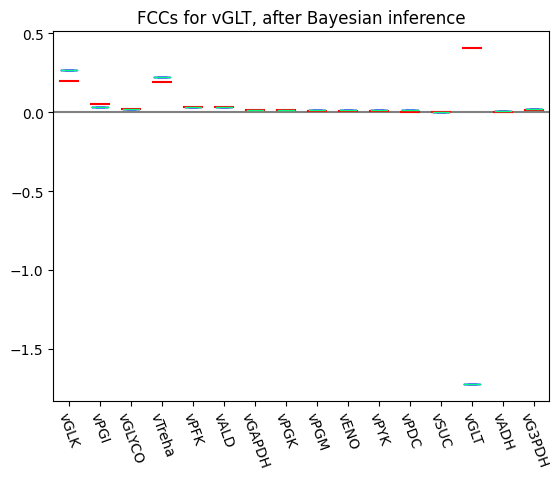

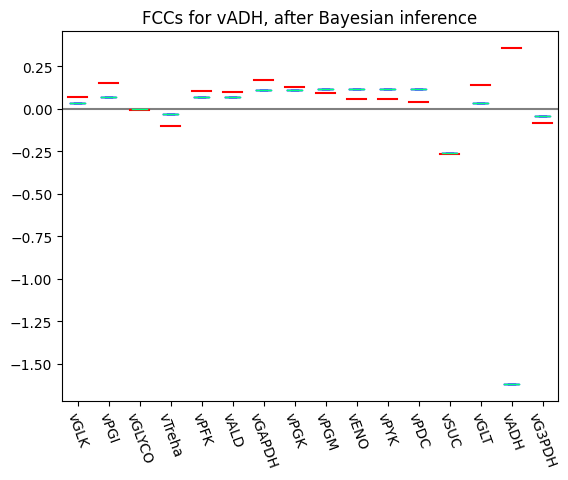

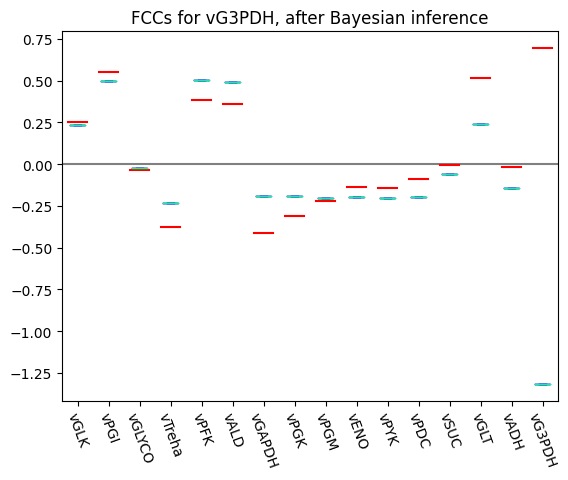

In [37]:
postCCC, postFCC = estimate_CCs(BIOMD64, med_Ex)
for i,rxnID in enumerate(r.getReactionIds()):
    FCCs = -pd.DataFrame(postFCC[:,i,:], columns=r.getReactionIds())
    # FCCs = pd.DataFrame(postFCC[:,i,:], columns=r.getReactionIds())

    FCCs.plot(kind='box', colormap='winter')
    plt.title(f'FCCs for {rxnID}, after Bayesian inference')
    plt.axhline(0, c='gray')

    for i,val in enumerate(gtFCC.loc[rxnID]): # .sort_index()
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[rxnID]), # From the left
                xmax = (i+0.8)/len(gtFCC[rxnID]), 
                c='red') # To the right
    plt.xticks(rotation=-70)
# plt.ylim((-1,3))